### DCGAN  on MNIST

DCGAN is a Generative Adversarial Network (GAN) using CNN.

1. The discriminator learns to discriminate real from fake images.
2. The generator tries to fool the discriminator by generating fake images.
3. The generator + discriminator form an adversarial network.
4. DCGAN trains the discriminator and adversarial networks alternately.

During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the Adversarial network on how
to improve its ability to generate fake images.

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os

#### Buiding a Generator Model

Build a model using layers of BatchNorm-ReLU-Conv2DTranpose to generate fake images

In [2]:
def build_generator(image_size=28, input_size=100):
    
    model = tf.keras.Sequential()

    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    model.add(tf.keras.layers.Dense(7 * 7 * 128, input_shape=(input_size,)))
    model.add(tf.keras.layers.Reshape((7,7,128)))

    #Use ConvTranspose - 1
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, 
                                              padding='same')) #14,14,128

    #Use ConvTranspose - 2
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same'))

    #Use ConvTranspose - 3
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same'))

    #Use ConvTranspose - 4
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same'))

    #Output layer for Generator
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    return model

#### Building a Discriminator

In [3]:
def build_discriminator(data_shape=[28,28,1,]):
    
    model = tf.keras.Sequential()

    #Build the network
    model.add(tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same' , input_shape=data_shape)) #14,14,32
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')) #7x7x64
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')) #3x3x128
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')) #3x3x256

    #Flatten the output and build an output layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

#### Building Models for Training

In [4]:
def build_models():
    
    tf.keras.backend.clear_session()
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = build_discriminator(data_shape=(28,28,1,))
    
    #Define optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

#### Training Discriminator and Adversarial Models

In [5]:
def train_gan(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    image_size = 28
    
    # load MNIST dataset
    (train_x, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    
    #Make it 3D dataset - 28x28 to 28x28x1
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])

    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size]) #16, 100
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])  #64, 100
        fake_images = generator.predict(noise_input) #64, 28, 28, 1
        
        #2. Get real images from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes] #64, 28, 28, 1
        
        #3. Prepare input for training Discriminator
        X = np.concatenate((real_images, fake_images))  #128, 28, 28, 1
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1)) #64,1 -> 1
        y_fake = np.zeros((batch_size, 1)) #64,1 -> 0
        y = np.concatenate((y_real, y_fake)) #128, 1
        
        #5. Train Discriminator
        #discriminator.fit(x,y, epochs=1, batch_size=128)
        d_loss, d_acc = discriminator.train_on_batch(X, y)
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size]) #64, 100
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch(X, y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_dcgan.h5')

#### Save generator images

In [6]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

### Start GAN Training

In [7]:
G, D, A = build_models()

C:\Users\19144\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
G.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)     

In [9]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [10]:
A.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                   

2/2 [==============================] - 1s 225ms/step
0 [Discriminator loss: 0.695119, acc: 0.500000, Adversarial loss: 0.805055, acc: 0.000000]
2/2 [==============================] - 0s 92ms/step
100 [Discriminator loss: 0.005925, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 102ms/step
200 [Discriminator loss: 0.000209, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 106ms/step
300 [Discriminator loss: 0.000112, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
2/2 [==============================] - 0s 133ms/step
400 [Discriminator loss: 0.000424, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
1/1 [==============================] - 0s 463ms/step


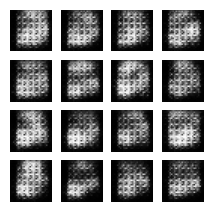

2/2 [==============================] - 0s 104ms/step
500 [Discriminator loss: 0.797680, acc: 0.523438, Adversarial loss: 2.349911, acc: 0.015625]
2/2 [==============================] - 0s 83ms/step
600 [Discriminator loss: 0.474654, acc: 0.812500, Adversarial loss: 0.608015, acc: 0.640625]
2/2 [==============================] - 0s 113ms/step
700 [Discriminator loss: 0.525239, acc: 0.734375, Adversarial loss: 0.620161, acc: 0.609375]
2/2 [==============================] - 0s 96ms/step
800 [Discriminator loss: 0.527442, acc: 0.773438, Adversarial loss: 1.026618, acc: 0.281250]
2/2 [==============================] - 0s 97ms/step
900 [Discriminator loss: 0.492611, acc: 0.734375, Adversarial loss: 1.225912, acc: 0.078125]
1/1 [==============================] - 0s 100ms/step


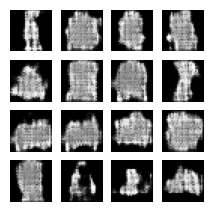

2/2 [==============================] - 1s 108ms/step
1000 [Discriminator loss: 0.525216, acc: 0.742188, Adversarial loss: 0.722433, acc: 0.500000]
2/2 [==============================] - 0s 118ms/step
1100 [Discriminator loss: 0.450020, acc: 0.750000, Adversarial loss: 1.935490, acc: 0.046875]
2/2 [==============================] - 0s 101ms/step
1200 [Discriminator loss: 0.459149, acc: 0.765625, Adversarial loss: 1.374661, acc: 0.031250]
2/2 [==============================] - 0s 105ms/step
1300 [Discriminator loss: 0.507960, acc: 0.703125, Adversarial loss: 0.705776, acc: 0.531250]
2/2 [==============================] - 0s 112ms/step
1400 [Discriminator loss: 0.491074, acc: 0.750000, Adversarial loss: 1.180726, acc: 0.125000]
1/1 [==============================] - 0s 79ms/step


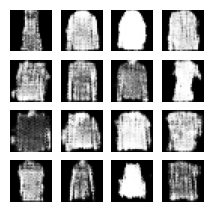

2/2 [==============================] - 0s 83ms/step
1500 [Discriminator loss: 0.411368, acc: 0.820312, Adversarial loss: 2.170176, acc: 0.031250]
2/2 [==============================] - 0s 137ms/step
1600 [Discriminator loss: 0.480693, acc: 0.765625, Adversarial loss: 1.275653, acc: 0.078125]
2/2 [==============================] - 0s 146ms/step
1700 [Discriminator loss: 0.552090, acc: 0.671875, Adversarial loss: 0.830712, acc: 0.375000]
2/2 [==============================] - 0s 87ms/step
1800 [Discriminator loss: 0.512262, acc: 0.718750, Adversarial loss: 2.008831, acc: 0.015625]
2/2 [==============================] - 0s 110ms/step
1900 [Discriminator loss: 0.463190, acc: 0.765625, Adversarial loss: 1.067844, acc: 0.171875]
1/1 [==============================] - 0s 178ms/step


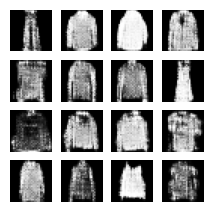

2/2 [==============================] - 0s 156ms/step
2000 [Discriminator loss: 0.429114, acc: 0.859375, Adversarial loss: 1.273539, acc: 0.078125]
2/2 [==============================] - 0s 149ms/step
2100 [Discriminator loss: 0.447802, acc: 0.781250, Adversarial loss: 1.200125, acc: 0.046875]
2/2 [==============================] - 0s 138ms/step
2200 [Discriminator loss: 0.494077, acc: 0.757812, Adversarial loss: 1.373588, acc: 0.046875]
2/2 [==============================] - 0s 121ms/step
2300 [Discriminator loss: 0.453823, acc: 0.820312, Adversarial loss: 1.157442, acc: 0.156250]
2/2 [==============================] - 0s 101ms/step
2400 [Discriminator loss: 0.441087, acc: 0.757812, Adversarial loss: 1.176477, acc: 0.062500]
1/1 [==============================] - 0s 79ms/step


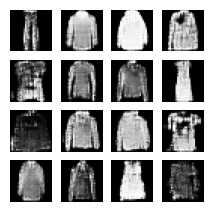

2/2 [==============================] - 0s 115ms/step
2500 [Discriminator loss: 0.594917, acc: 0.679688, Adversarial loss: 0.997541, acc: 0.171875]
2/2 [==============================] - 0s 122ms/step
2600 [Discriminator loss: 0.424795, acc: 0.828125, Adversarial loss: 1.343235, acc: 0.078125]
2/2 [==============================] - 0s 128ms/step
2700 [Discriminator loss: 0.654726, acc: 0.656250, Adversarial loss: 0.751501, acc: 0.531250]
2/2 [==============================] - 0s 121ms/step
2800 [Discriminator loss: 0.428279, acc: 0.796875, Adversarial loss: 1.468786, acc: 0.046875]
2/2 [==============================] - 0s 123ms/step
2900 [Discriminator loss: 0.505208, acc: 0.718750, Adversarial loss: 1.754706, acc: 0.062500]
1/1 [==============================] - 0s 106ms/step


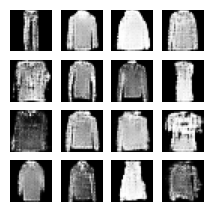

2/2 [==============================] - 0s 160ms/step
3000 [Discriminator loss: 0.483442, acc: 0.679688, Adversarial loss: 1.880243, acc: 0.000000]
2/2 [==============================] - 0s 143ms/step
3100 [Discriminator loss: 0.477841, acc: 0.750000, Adversarial loss: 1.282320, acc: 0.093750]
2/2 [==============================] - 0s 179ms/step
3200 [Discriminator loss: 0.515198, acc: 0.742188, Adversarial loss: 1.438328, acc: 0.093750]
2/2 [==============================] - 0s 127ms/step
3300 [Discriminator loss: 0.522677, acc: 0.750000, Adversarial loss: 1.088663, acc: 0.234375]
2/2 [==============================] - 0s 182ms/step
3400 [Discriminator loss: 0.488764, acc: 0.750000, Adversarial loss: 1.460737, acc: 0.078125]
1/1 [==============================] - 0s 86ms/step


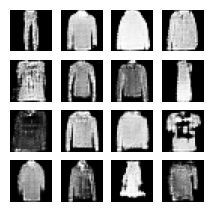

2/2 [==============================] - 0s 172ms/step
3500 [Discriminator loss: 0.501861, acc: 0.742188, Adversarial loss: 1.262651, acc: 0.109375]
2/2 [==============================] - 0s 175ms/step
3600 [Discriminator loss: 0.487448, acc: 0.742188, Adversarial loss: 1.187680, acc: 0.093750]
2/2 [==============================] - 0s 182ms/step
3700 [Discriminator loss: 0.524359, acc: 0.695312, Adversarial loss: 1.406958, acc: 0.046875]
2/2 [==============================] - 0s 202ms/step
3800 [Discriminator loss: 0.456962, acc: 0.789062, Adversarial loss: 1.182997, acc: 0.093750]
2/2 [==============================] - 0s 172ms/step
3900 [Discriminator loss: 0.495028, acc: 0.726562, Adversarial loss: 1.274023, acc: 0.078125]
1/1 [==============================] - 0s 123ms/step


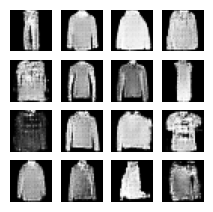

2/2 [==============================] - 0s 176ms/step
4000 [Discriminator loss: 0.484120, acc: 0.773438, Adversarial loss: 1.157081, acc: 0.140625]
2/2 [==============================] - 0s 217ms/step
4100 [Discriminator loss: 0.430431, acc: 0.796875, Adversarial loss: 1.009244, acc: 0.218750]
2/2 [==============================] - 1s 251ms/step
4200 [Discriminator loss: 0.484189, acc: 0.765625, Adversarial loss: 1.164989, acc: 0.109375]
2/2 [==============================] - 0s 170ms/step
4300 [Discriminator loss: 0.447687, acc: 0.781250, Adversarial loss: 1.324932, acc: 0.015625]
2/2 [==============================] - 0s 145ms/step
4400 [Discriminator loss: 0.494303, acc: 0.703125, Adversarial loss: 1.164418, acc: 0.046875]
1/1 [==============================] - 0s 127ms/step


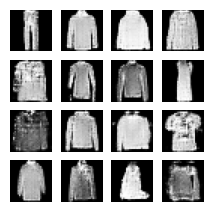

2/2 [==============================] - 0s 176ms/step
4500 [Discriminator loss: 0.416106, acc: 0.789062, Adversarial loss: 1.196939, acc: 0.125000]
2/2 [==============================] - 0s 160ms/step
4600 [Discriminator loss: 0.458983, acc: 0.750000, Adversarial loss: 1.168671, acc: 0.125000]
2/2 [==============================] - 0s 155ms/step
4700 [Discriminator loss: 0.460085, acc: 0.765625, Adversarial loss: 1.273293, acc: 0.140625]
2/2 [==============================] - 0s 184ms/step
4800 [Discriminator loss: 0.463614, acc: 0.765625, Adversarial loss: 1.301900, acc: 0.078125]
2/2 [==============================] - 0s 155ms/step
4900 [Discriminator loss: 0.492357, acc: 0.742188, Adversarial loss: 1.370770, acc: 0.062500]
1/1 [==============================] - 0s 126ms/step


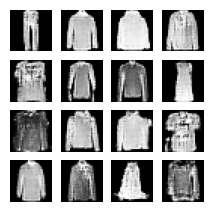

2/2 [==============================] - 0s 214ms/step
5000 [Discriminator loss: 0.492832, acc: 0.773438, Adversarial loss: 0.969736, acc: 0.218750]
2/2 [==============================] - 0s 201ms/step
5100 [Discriminator loss: 0.510247, acc: 0.718750, Adversarial loss: 0.993470, acc: 0.250000]
2/2 [==============================] - 0s 234ms/step
5200 [Discriminator loss: 0.454802, acc: 0.796875, Adversarial loss: 1.189247, acc: 0.125000]
2/2 [==============================] - 0s 188ms/step
5300 [Discriminator loss: 0.429135, acc: 0.812500, Adversarial loss: 1.091880, acc: 0.218750]
2/2 [==============================] - 0s 215ms/step
5400 [Discriminator loss: 0.458086, acc: 0.796875, Adversarial loss: 1.514426, acc: 0.000000]
1/1 [==============================] - 0s 151ms/step


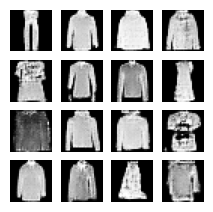

2/2 [==============================] - 0s 227ms/step
5500 [Discriminator loss: 0.549466, acc: 0.750000, Adversarial loss: 1.503199, acc: 0.078125]
2/2 [==============================] - 0s 208ms/step
5600 [Discriminator loss: 0.461281, acc: 0.781250, Adversarial loss: 1.108832, acc: 0.171875]
2/2 [==============================] - 1s 283ms/step
5700 [Discriminator loss: 0.413029, acc: 0.812500, Adversarial loss: 1.121023, acc: 0.171875]
2/2 [==============================] - 0s 219ms/step
5800 [Discriminator loss: 0.420979, acc: 0.812500, Adversarial loss: 1.464456, acc: 0.031250]
2/2 [==============================] - 1s 227ms/step
5900 [Discriminator loss: 0.475510, acc: 0.750000, Adversarial loss: 1.226407, acc: 0.109375]
1/1 [==============================] - 0s 224ms/step


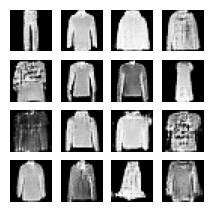

2/2 [==============================] - 1s 309ms/step
6000 [Discriminator loss: 0.449630, acc: 0.757812, Adversarial loss: 1.350478, acc: 0.062500]
2/2 [==============================] - 1s 299ms/step
6100 [Discriminator loss: 0.560810, acc: 0.687500, Adversarial loss: 0.918790, acc: 0.328125]
2/2 [==============================] - 1s 235ms/step
6200 [Discriminator loss: 0.462713, acc: 0.750000, Adversarial loss: 0.861259, acc: 0.437500]
2/2 [==============================] - 0s 236ms/step
6300 [Discriminator loss: 0.493548, acc: 0.718750, Adversarial loss: 1.511667, acc: 0.062500]
2/2 [==============================] - 0s 207ms/step
6400 [Discriminator loss: 0.487796, acc: 0.710938, Adversarial loss: 1.240601, acc: 0.078125]
1/1 [==============================] - 0s 147ms/step


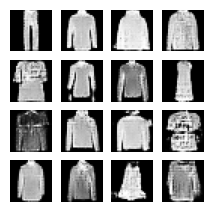

2/2 [==============================] - 1s 280ms/step
6500 [Discriminator loss: 0.478869, acc: 0.757812, Adversarial loss: 1.542038, acc: 0.031250]
2/2 [==============================] - 1s 429ms/step
6600 [Discriminator loss: 0.399334, acc: 0.828125, Adversarial loss: 1.227739, acc: 0.125000]
2/2 [==============================] - 1s 285ms/step
6700 [Discriminator loss: 0.510720, acc: 0.734375, Adversarial loss: 1.320772, acc: 0.093750]
2/2 [==============================] - 1s 324ms/step
6800 [Discriminator loss: 0.406694, acc: 0.828125, Adversarial loss: 1.417089, acc: 0.062500]
2/2 [==============================] - 0s 239ms/step
6900 [Discriminator loss: 0.509314, acc: 0.734375, Adversarial loss: 1.556918, acc: 0.046875]
1/1 [==============================] - 0s 207ms/step


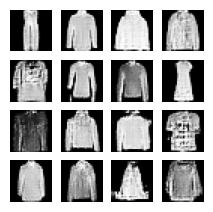

2/2 [==============================] - 1s 392ms/step
7000 [Discriminator loss: 0.446682, acc: 0.757812, Adversarial loss: 1.317643, acc: 0.109375]
2/2 [==============================] - 1s 236ms/step
7100 [Discriminator loss: 0.513907, acc: 0.718750, Adversarial loss: 1.013581, acc: 0.234375]
2/2 [==============================] - 1s 282ms/step
7200 [Discriminator loss: 0.441476, acc: 0.765625, Adversarial loss: 0.978567, acc: 0.328125]
2/2 [==============================] - 1s 321ms/step
7300 [Discriminator loss: 0.467553, acc: 0.789062, Adversarial loss: 1.091097, acc: 0.250000]
2/2 [==============================] - 1s 289ms/step
7400 [Discriminator loss: 0.513513, acc: 0.679688, Adversarial loss: 0.983812, acc: 0.375000]
2/2 [==============================] - 1s 303ms/step


In [ ]:
train_gan(G, D, A)

In [ ]:
def generate_images():

    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, 100]) #16, 100
    
    #Generate 16 images
    fake_images = G.predict(test_noise_input)
    
    #Display images
    plot_images(fake_images, None)

In [ ]:
generate_images()